In [114]:
import numpy as np
import cv2
from itertools import cycle
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.utils import to_categorical
from keras.preprocessing.image import img_to_array, array_to_img, img_to_array, load_img
from keras.datasets import cifar10


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
# x_train.shape
for i in x_train[:10]:
    t = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    print(i.shape, t.shape)

(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)


In [4]:
def rgb_to_grayscale(images):
    grayscale_images = []
    for image in images:
        # Convert using OpenCV's BGR to grayscale conversion (assumes BGR format)
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grayscale_images.append(grayscale_image)
    return np.array(grayscale_images)

# Apply grayscale conversion
x_train_gray = rgb_to_grayscale(x_train)
x_test_gray = rgb_to_grayscale(x_test)

x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], 32, 32, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], 32, 32, 1)

# Normalize pixel values (optional but recommended)
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

#### Task 1: Perform standard PCA and identify the eigenvectors associated with top eigenvalues with 95% total energy (i,e.,  >=95 percent). Using these, train a logistic regression classifier to classify the images into 10 classes. Draw the ROC curve for the test dataset. Repeat the same with randomized PCA and compare.

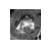

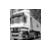

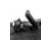

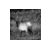

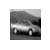

In [5]:
num_images_to_print = 5
for i in range(num_images_to_print):
    plt.figure(figsize=(0.4,0.4))
    plt.imshow(x_train_gray[i], cmap='gray')
    # plt.title(f'Grayscale Image {i+1}')
    plt.axis('off')
plt.show()

In [62]:
num_images = x_train_gray.shape[0]
num_images_test = x_test_gray.shape[0]

image_size = np.prod(x_train_gray.shape[1:])
image_size_test = np.prod(x_test_gray.shape[1:])

x_flat = x_train_gray.reshape(num_images, image_size)
x_test_flat = x_test_gray.reshape(num_images_test, image_size_test)

# begin normalisation for pca
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_flat)
X_test_scaled = scaler.transform(x_test_flat)

pca = PCA(svd_solver='full')
pca.fit(X_scaled)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(n_components)

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
X_pca_test = pca.transform(X_test_scaled)

num_images, image_size, X_scaled.shape, X_pca.shape, X_pca_test.shape

159


(50000, 1024, (50000, 1024), (50000, 159), (10000, 159))

In [84]:
random_pca = PCA(svd_solver='randomized')
random_pca.fit(X_scaled)
random_cumulative_variance_ratio = np.cumsum(random_pca.explained_variance_ratio_)
nr_components = np.argmax(random_cumulative_variance_ratio >= 0.94) + 1
print(nr_components)

random_pca = PCA(n_components=nr_components, svd_solver='randomized')
X_pca_random = random_pca.fit_transform(X_scaled)
X_pca_random_test = random_pca.transform(X_test_scaled)
print(X_pca_random.shape, X_pca_random_test.shape)

135
(50000, 135) (10000, 135)


In [85]:
y_train_ = label_binarize(y_train, classes=np.arange(10))
y_test_ = label_binarize(y_test, classes=np.arange(10))

In [86]:
classifier = OneVsRestClassifier(LogisticRegression(random_state=1000, max_iter=10000, multi_class='multinomial', tol=0.1, class_weight='balanced', n_jobs=-1, verbose=0, C=100))
classifier.fit(X_pca, y_train_)
y_prob = classifier.predict_proba(X_pca)
y_pred = classifier.predict(X_pca)
y_pred_test = classifier.predict(X_pca_test)

accuracy = accuracy_score(y_train_, y_pred)
accuracy_test = accuracy_score(y_test_, y_pred_test)
print(accuracy, accuracy_test)


0.01036 0.0115


(10000, 10)


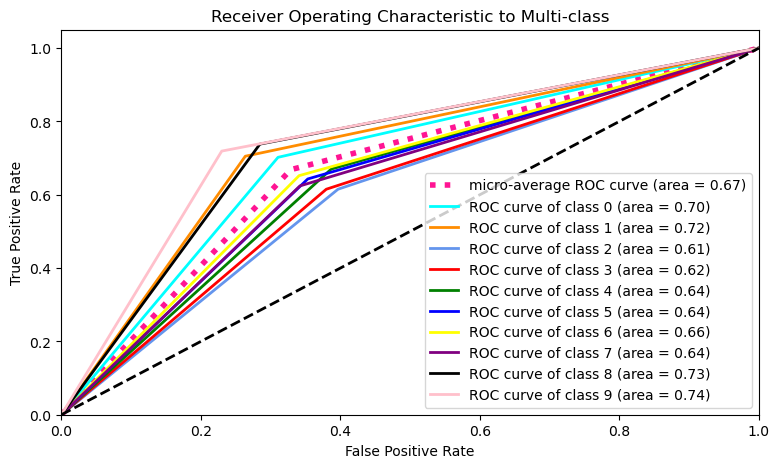

In [87]:
# plot one vs rest auc roc curve
def make_roc_plot_10(y_train_, y_pred):
    print(y_train_.shape)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 10

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_train_[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_train_.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.figure(figsize=(9,5))
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'yellow', 'purple', 'black', 'pink'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic to Multi-class')
    plt.legend(loc="lower right")
    plt.show()
    return

# make_roc_plot_10(y_train_, y_pred)
make_roc_plot_10(y_test_, y_pred_test)

0.01042 0.0103
(10000, 10)


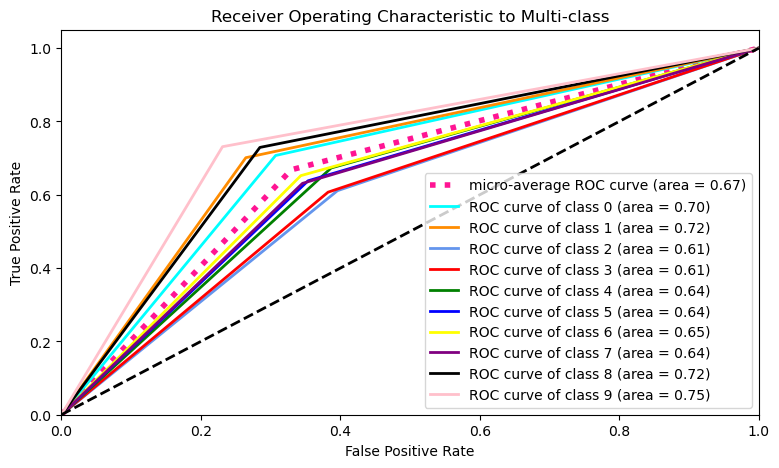

In [83]:
classifier_randomised = OneVsRestClassifier(LogisticRegression(random_state=1000, max_iter=10000, multi_class='multinomial', tol=0.1, class_weight='balanced', n_jobs=-1, verbose=0, C=100))
classifier_randomised.fit(X_pca_random, y_train_)
y_prob = classifier_randomised.predict_proba(X_pca_random)
y_pred_random = classifier_randomised.predict(X_pca_random)
y_pred_random_test = classifier_randomised.predict(X_pca_random_test)

accuracy_random = accuracy_score(y_train_, y_pred)
accuracy_random_test = accuracy_score(y_test_, y_pred_random_test)
print(accuracy_random, accuracy_random_test)

make_roc_plot_10(y_test_, y_pred_random_test)

#### Task 2: Train a single layer autoencoder with linear activation function and appropriate normalization of the input. Compare the eigenvectors obtained in step 1 with those obtained using the autoencoders. Explain your observations.

In [92]:
input_dim = X_scaled.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(159, activation='linear')(input_layer)
encoder = Model(inputs=input_layer, outputs=encoded)
decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

num_epochs = 50
batch_size = 32

history = autoencoder.fit(X_scaled, X_scaled,
                          epochs=num_epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test_scaled, X_test_scaled))

encoder_output = encoder.predict(X_test_scaled)
reconstructed = autoencoder.predict(X_test_scaled)
reconstructed_original_scale = scaler.inverse_transform(reconstructed)

# Print a sample of the original and reconstructed data for comparison
print("Original Data Sample:\n", scaler.inverse_transform(X_test_scaled[:5]))
print("Reconstructed Data Sample:\n", reconstructed_original_scale[:5])

# Print a sample of the encoder output
print("Encoder Output Sample:\n", encoder_output[:1])

Epoch 1/50
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1161 - val_loss: 0.0618
Epoch 2/50
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0598 - val_loss: 0.0632
Epoch 3/50
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0578 - val_loss: 0.0571
Epoch 4/50
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0569 - val_loss: 0.0567
Epoch 5/50
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0565 - val_loss: 0.0556
Epoch 6/50
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0562 - val_loss: 0.0567
Epoch 7/50
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0562 - val_loss: 0.0556
Epoch 8/50
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0559 - val_loss: 0.0565
Epoch 9/50
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0559 - val_loss: 0.0555
Epoch 10/50
1563/1563 [==============================] - 5s 3ms/step - loss: 0.056

In [122]:
# comparing outputs:
for i in range(159):
    print(encoder_output[:1][0][i], X_pca[:1][0][i])

-1.0678906 -15.664891
-0.0935131 6.355103
-0.31153557 7.185326
-0.72217625 -0.4486179
-0.5631118 -2.420145
0.621614 -1.0724885
-0.21648668 -4.251442
-0.022652194 7.091633
-0.067078 2.7618787
-0.16440271 0.29321617
0.4230731 -0.14849116
0.07085561 1.5378901
0.033088606 1.9008461
-1.8993187 2.7086294
0.17433009 -1.5482951
-0.7508585 -0.83435565
-0.83286804 -0.5667133
1.0195061 1.2948241
0.032107923 -2.7279482
0.33659622 1.3648312
-1.1949369 2.4195776
0.49524745 -3.2354627
0.75230914 2.2592757
0.23114403 3.5542176
-0.26568076 1.439657
-0.580386 -1.2737516
-0.31530556 0.22301877
-2.109627 -1.1088941
0.26669988 -2.24315
0.033618286 -0.5166557
-1.106239 4.7901235
-0.80289036 -0.2157447
0.49110818 -0.5924464
0.8635936 0.6286403
0.95316726 1.1471488
-0.009605266 -1.4217275
0.34796774 1.4951239
0.99615735 2.502048
-0.41896483 0.73140174
-0.77888197 0.44317824
0.25666913 0.22468194
0.48979208 -0.69794077
-0.004558315 0.12674327
0.35378072 -0.45283833
0.7732768 1.8815709
-0.023900313 1.5806348
-0

#### Task 3: Train an appropriate deep convolutional autoencoder with same dimension of latent space. Calculate the reconstruction error and compare that with a single hidden layer autoencoder (with sigmoid activation at the autoencoder and linear at the decoder) for the test dataset. What will be the reconstruction error if the hidden nodes are distributed equally (approximately) among 3 hidden layers in a new 3 hidden layer autoencoder with sigmoid activation at the autoencoder and linear at the decoder final layer.

In [127]:
latent_dim = 159

# Define the encoder
input_img = Input(shape=(32, 32, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Define the decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Build the autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(x_train_gray, x_train_gray,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_gray, x_test_gray))

# Extract the encoder model
encoder = Model(input_img, encoded)


#### Task 4. Train a deep convolutional autoencoder with MNIST dataset and using extracted features train a MLP classifier with 7 outputs (7 segment LED display) that are representative of 10 digits. For example images of "0" will be classified as